Columns in dataset: ['SampleNo.', 'AtterbergLimits.LL.%', 'AtterbergLimits.PL.%', 'AtterbergLimits.PI.%', 'AtterbergLimits.LS.%', 'CompactionT180.MDD.Kgm3', 'CompactionT180.OMC.(%)', 'CBR.4daysSoak.(%)', 'Swell.(%)', 'SoilComposition.Gravel.(%)', 'SoilComposition.Sand.(%)', 'SoilComposition.SiltClay.(%)']
Dataset shape: (83, 12)
Numeric columns: 12
Categorical columns: 0
Standardized 11 columns
Using CBR.4daysSoak.(%) as the target column
Features used for training (10): ['AtterbergLimits.LL.%', 'AtterbergLimits.PL.%', 'AtterbergLimits.PI.%', 'AtterbergLimits.LS.%', 'CompactionT180.MDD.Kgm3', 'CompactionT180.OMC.(%)', 'Swell.(%)', 'SoilComposition.Gravel.(%)', 'SoilComposition.Sand.(%)', 'SoilComposition.SiltClay.(%)']
Target variable: CBR.4daysSoak.(%)
Target range: -1.41 to 5.63
Training samples: 66, Test samples: 17

MODEL PERFORMANCE (WITHOUT DOSAGE)
RMSE: 0.54
R²: 0.569

Top 10 features by RandomForest importance:
                        Feature  Importance
9  SoilComposition.Silt

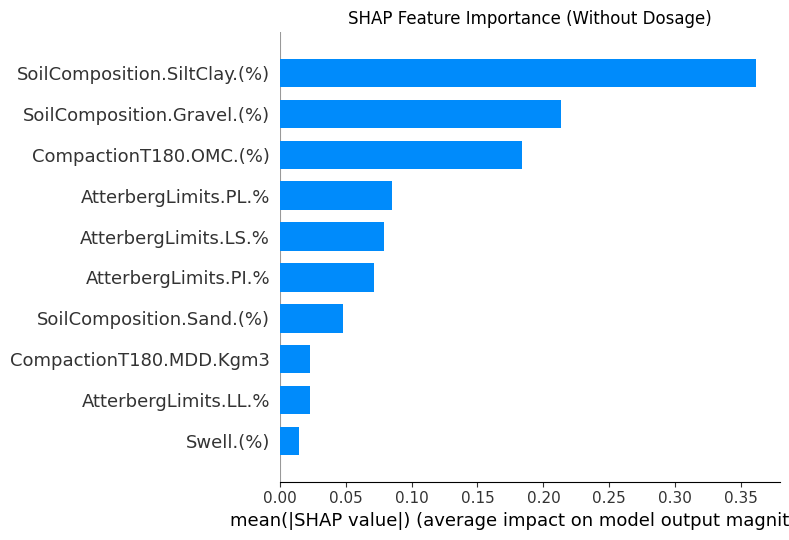

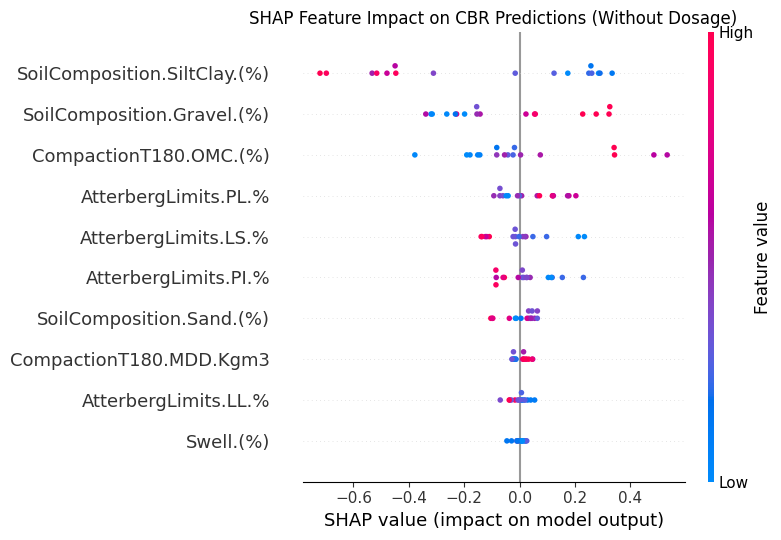

<Figure size 1000x600 with 0 Axes>

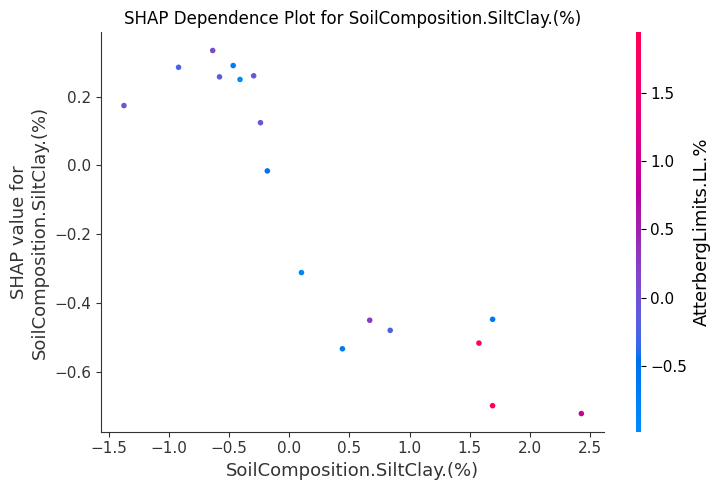

<Figure size 2000x300 with 0 Axes>

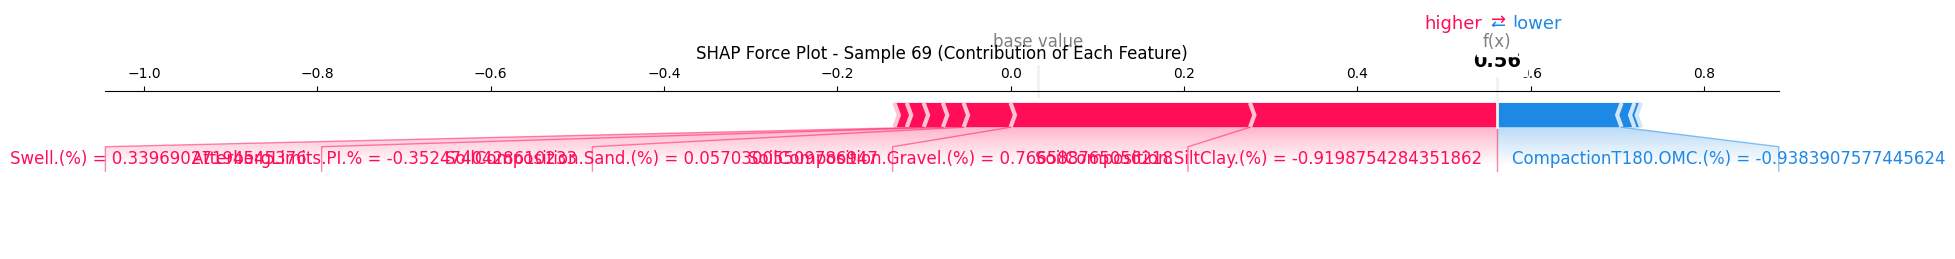

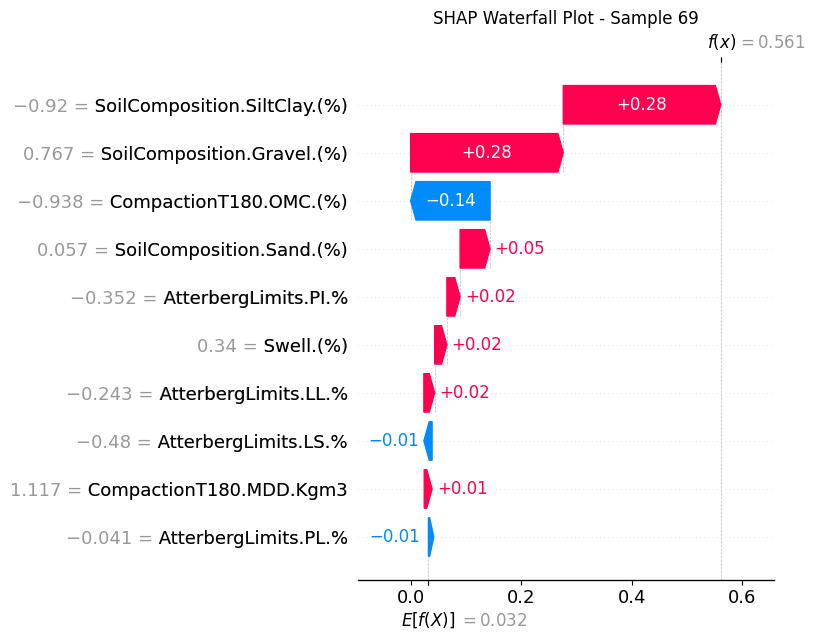


ADDITIONAL INSIGHTS
Top 5 features by SHAP importance:
                        Feature  SHAP_Importance
9  SoilComposition.SiltClay.(%)         0.361391
7    SoilComposition.Gravel.(%)         0.213663
5        CompactionT180.OMC.(%)         0.183927
1          AtterbergLimits.PL.%         0.085339
3          AtterbergLimits.LS.%         0.078967

Top 5 features by correlation with CBR.4daysSoak.(%):
SoilComposition.SiltClay.(%)    0.498455
SoilComposition.Gravel.(%)      0.496427
AtterbergLimits.LS.%            0.344863
AtterbergLimits.PI.%            0.281495
CompactionT180.MDD.Kgm3         0.269552
dtype: float64

Note: This model excludes Dosage.% which may be important for CBR prediction
Current R² of 0.569 suggests moderate predictive power


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

# Load the cleaned data
df = pd.read_csv('cleaned_MTRD_Soils_data500.csv')

# Print columns for debugging
print("Columns in dataset:", df.columns.tolist())
print(f"Dataset shape: {df.shape}")

# Handle missing values properly - separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Fill numeric columns with their means
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill categorical columns with the most frequent value (mode)
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")

# Standardize numerical features - EXCLUDE SampleNo and Dosage
scaler = StandardScaler()
numerical_cols_for_scaling = [col for col in numeric_cols if col not in ['SampleNo.', 'Dosage.%']]
df[numerical_cols_for_scaling] = scaler.fit_transform(df[numerical_cols_for_scaling])

print(f"Standardized {len(numerical_cols_for_scaling)} columns")

# Define features and target - find CBR column
target_col = 'CBR.(%)'
if target_col not in df.columns:
    # If column name is slightly different, find the closest match
    possible_targets = [col for col in df.columns if 'CBR' in col]
    if possible_targets:
        target_col = possible_targets[0]
        print(f"Using {target_col} as the target column")
    else:
        raise ValueError("Target column 'CBR.(%)' not found in the dataset")

# Define features - EXCLUDE SampleNo and Dosage
cols_to_drop = [target_col]
if 'SampleNo.' in df.columns:
    cols_to_drop.append('SampleNo.')
if 'Dosage.%' in df.columns:
    cols_to_drop.append('Dosage.%')  # Explicitly exclude dosage

X = df.drop(cols_to_drop, axis=1)
y = df[target_col]

print(f"Features used for training ({len(X.columns)}):", X.columns.tolist())
print(f"Target variable: {target_col}")
print(f"Target range: {y.min():.2f} to {y.max():.2f}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("MODEL PERFORMANCE (WITHOUT DOSAGE)")
print("="*50)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Get feature importances for reference
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 features by RandomForest importance:")
print(importances.head(10))

# SHAP Analysis
print("\n" + "="*50)
print("SHAP ANALYSIS")
print("="*50)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
sample_size = min(100, X_test.shape[0])
sample_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
X_sample = X_test.iloc[sample_indices]

print(f"Calculating SHAP values for {sample_size} samples...")

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# 1. SHAP Summary Plot (Bar)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Without Dosage)")
plt.tight_layout()
plt.show()

# 2. SHAP Summary Plot (Detailed)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Feature Impact on CBR Predictions (Without Dosage)")
plt.tight_layout()
plt.show()

# 3. Dependence plot for most important feature
most_important_feature = importances['Feature'].iloc[0]
plt.figure(figsize=(10, 6))
shap.dependence_plot(most_important_feature, shap_values, X_sample, show=False)
plt.title(f"SHAP Dependence Plot for {most_important_feature}")
plt.tight_layout()
plt.show()

# 4. Force plot for a single prediction
sample_idx = 0
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, 
                shap_values[sample_idx,:], 
                X_sample.iloc[sample_idx,:], 
                matplotlib=True,
                show=False)
plt.title(f"SHAP Force Plot - Sample {X_sample.index[sample_idx]} (Contribution of Each Feature)")
plt.tight_layout()
plt.show()

# 5. Waterfall plot for better interpretation
fig, ax = plt.subplots(figsize=(12, 8))
shap.waterfall_plot(shap.Explanation(values=shap_values[sample_idx], 
                                   base_values=explainer.expected_value,
                                   data=X_sample.iloc[sample_idx],
                                   feature_names=X_sample.columns.tolist()),
                   show=False)
plt.title(f"SHAP Waterfall Plot - Sample {X_sample.index[sample_idx]}")
plt.tight_layout()
plt.show()

# Additional Analysis
print("\n" + "="*50)
print("ADDITIONAL INSIGHTS")
print("="*50)

# Compare RandomForest importance vs SHAP importance
shap_importance = pd.DataFrame({
    'Feature': X_sample.columns,
    'SHAP_Importance': np.abs(shap_values).mean(0)
}).sort_values('SHAP_Importance', ascending=False)

print("Top 5 features by SHAP importance:")
print(shap_importance.head(5))

# Feature correlation with target
feature_correlations = X.corrwith(y).abs().sort_values(ascending=False)
print(f"\nTop 5 features by correlation with {target_col}:")
print(feature_correlations.head(5))

print(f"\nNote: This model excludes Dosage.% which may be important for CBR prediction")
print(f"Current R² of {r2:.3f} suggests moderate predictive power")

INDIVIDUAL FEATURE LINEAR REGRESSION ANALYSIS
Analyzing 10 features against CBR.4daysSoak.(%)

Creating 10 individual regression plots...


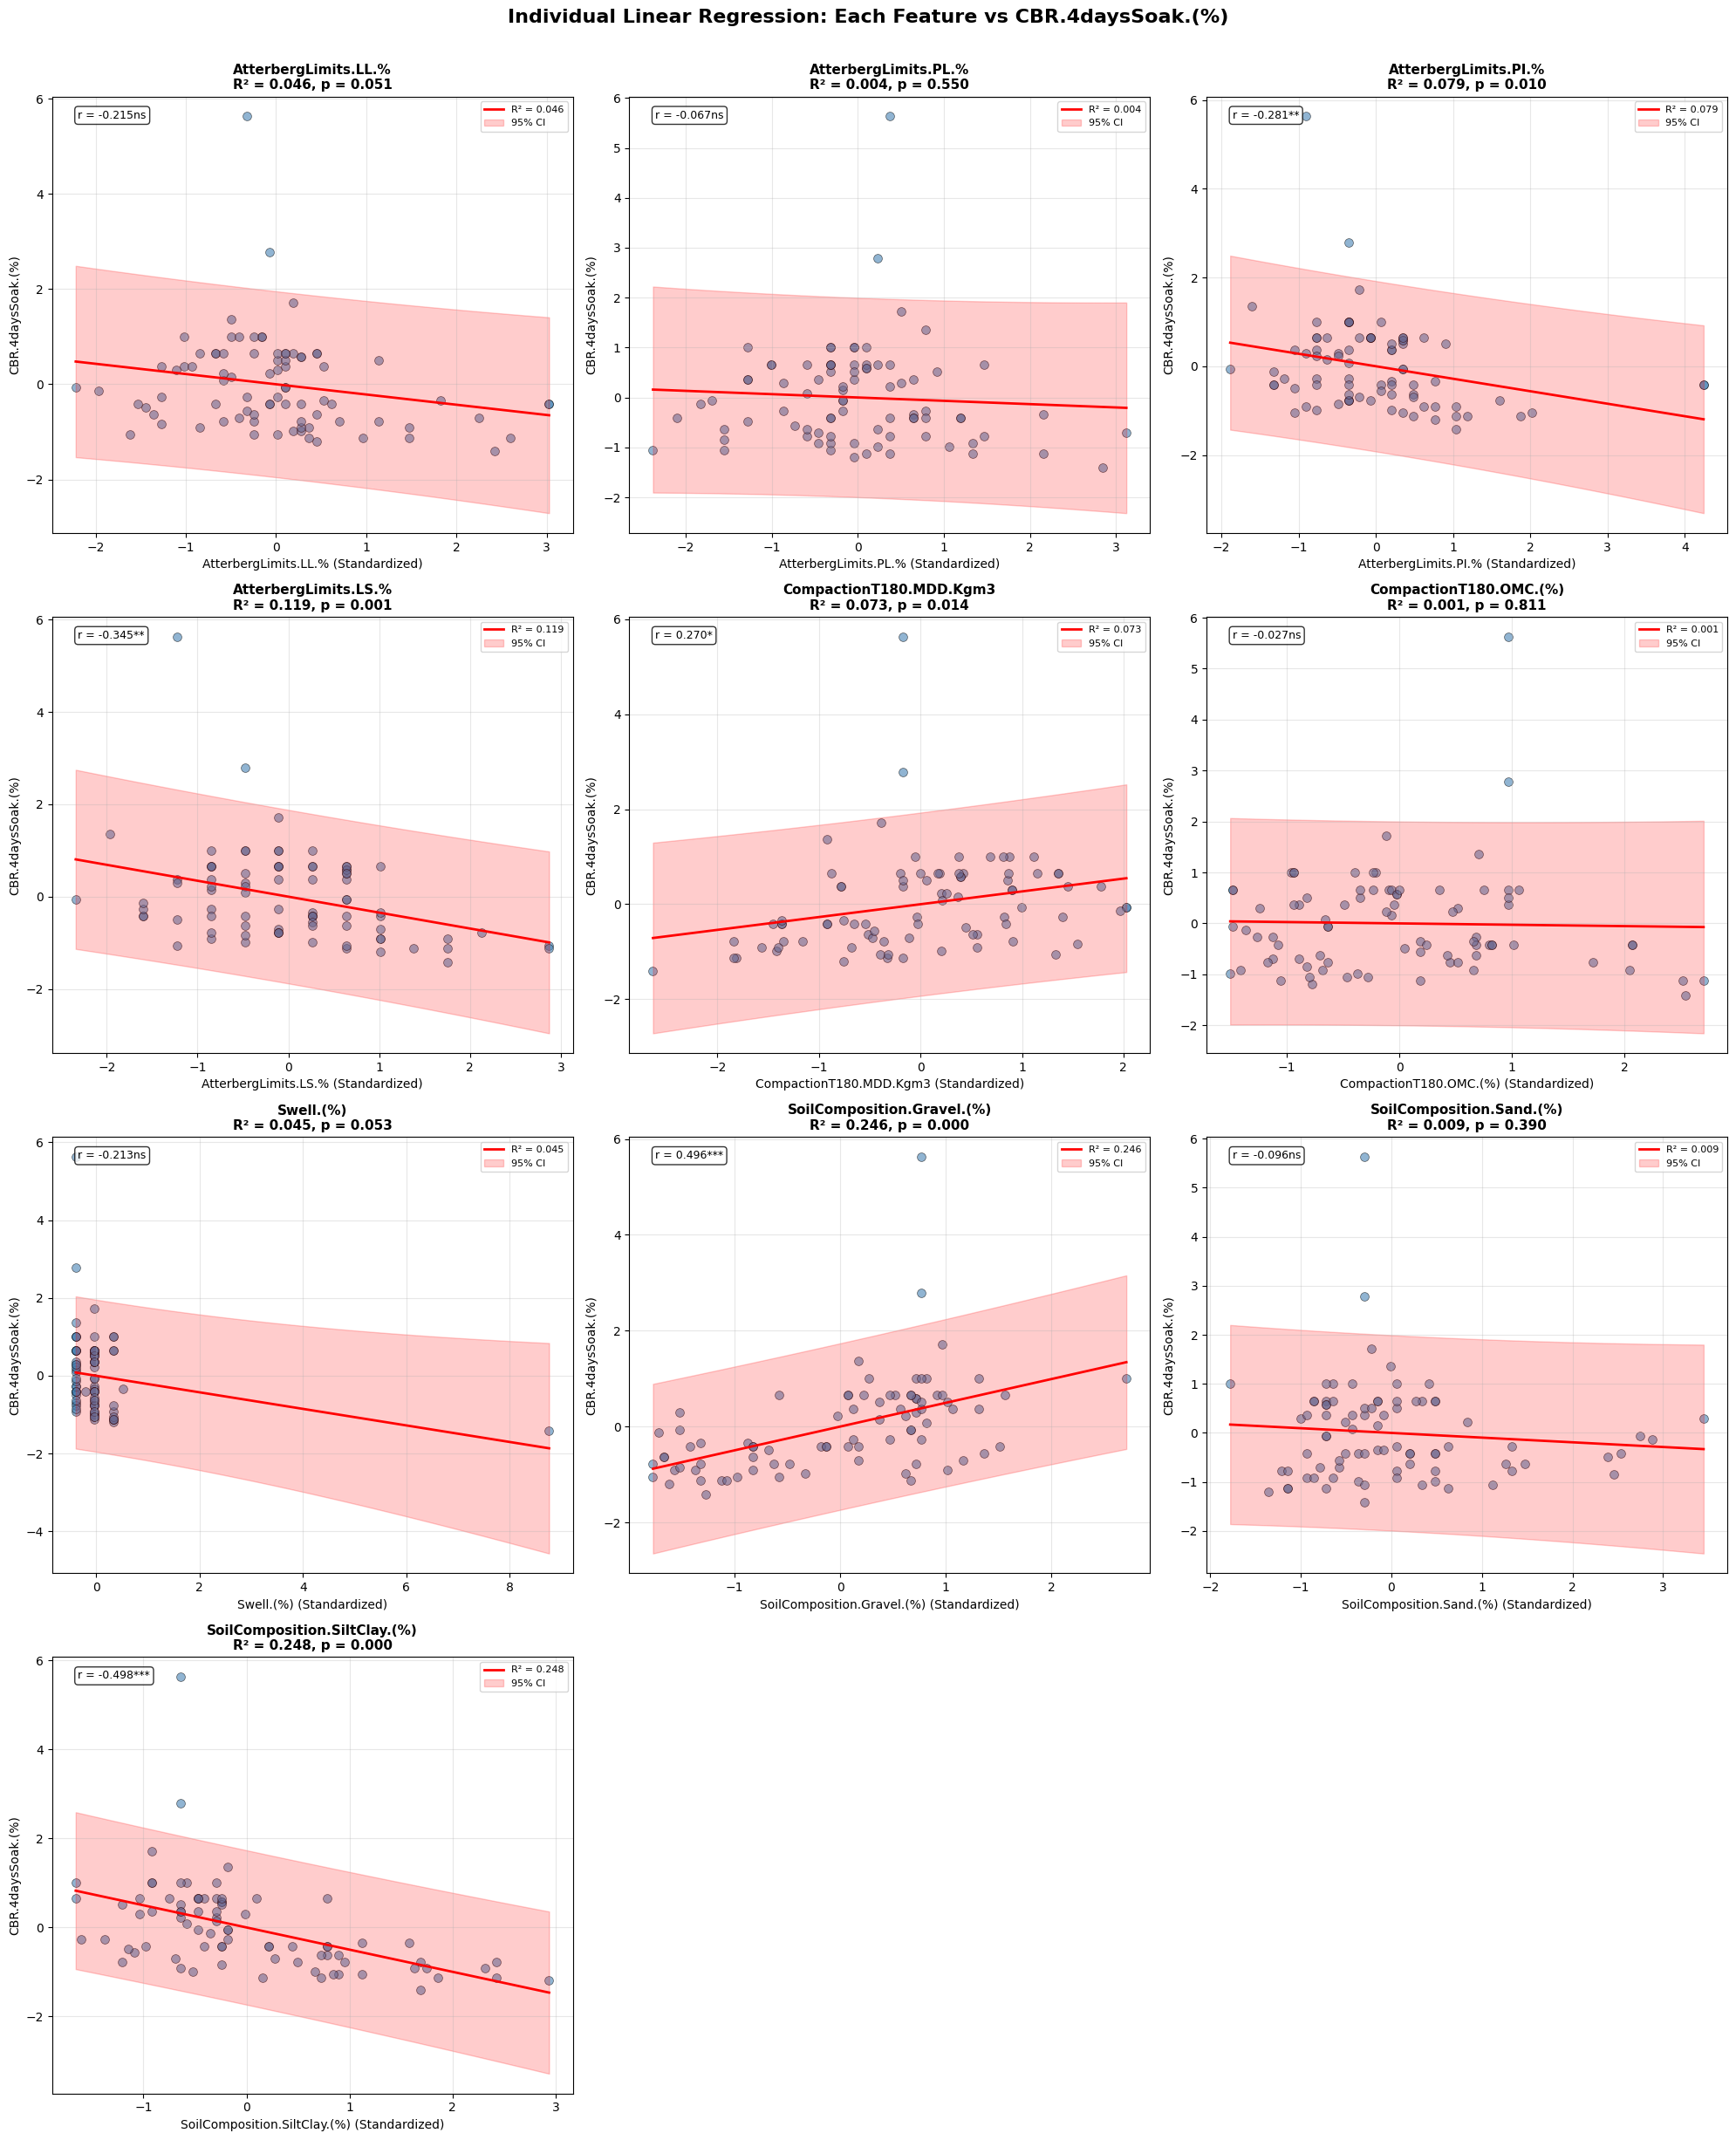


LINEAR REGRESSION RESULTS SUMMARY

TOP 10 FEATURES BY R² SCORE:
--------------------------------------------------
SoilComposition.SiltClay.(%)             R² = 0.248 ***
SoilComposition.Gravel.(%)               R² = 0.246 ***
AtterbergLimits.LS.%                     R² = 0.119 **
AtterbergLimits.PI.%                     R² = 0.079 **
CompactionT180.MDD.Kgm3                  R² = 0.073 *
AtterbergLimits.LL.%                     R² = 0.046 
Swell.(%)                                R² = 0.045 
SoilComposition.Sand.(%)                 R² = 0.009 
AtterbergLimits.PL.%                     R² = 0.004 
CompactionT180.OMC.(%)                   R² = 0.001 

STATISTICAL SIGNIFICANCE SUMMARY:
Features with significant correlation (p < 0.05): 5/10
Highly significant (p < 0.001): 2
Very significant (p < 0.01): 4


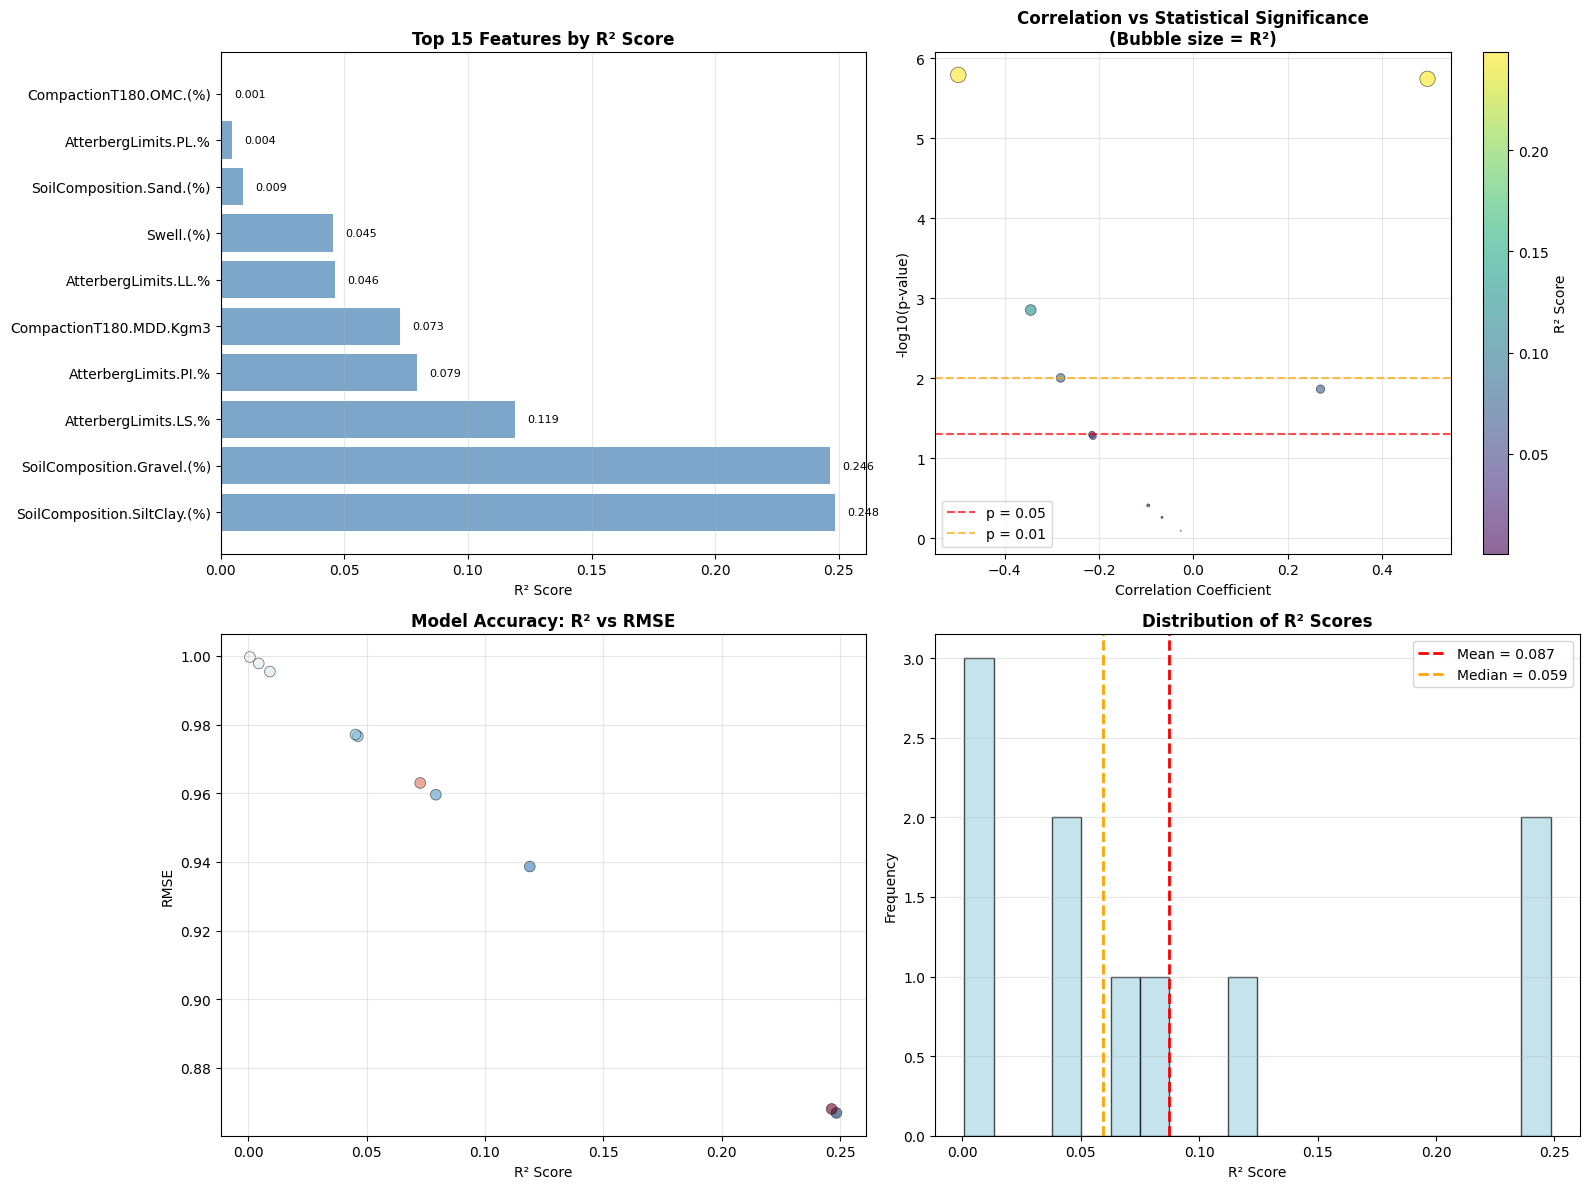


DETAILED RESULTS TABLE:
Feature                                  R²       RMSE     Correlation  P-value      Coefficient  Significant 
------------------------------------------------------------------------------------------------------------------------
SoilComposition.SiltClay.(%)             0.248    0.9      -0.498       0.000        -0.5         Yes         
SoilComposition.Gravel.(%)               0.246    0.9      0.496        0.000        0.5          Yes         
AtterbergLimits.LS.%                     0.119    0.9      -0.345       0.001        -0.3         Yes         
AtterbergLimits.PI.%                     0.079    1.0      -0.281       0.010        -0.3         Yes         
CompactionT180.MDD.Kgm3                  0.073    1.0      0.270        0.014        0.3          Yes         
AtterbergLimits.LL.%                     0.046    1.0      -0.215       0.051        -0.2         No          
Swell.(%)                                0.045    1.0      -0.213       0.053

In [8]:

# Add this new cell to your notebook after the existing SHAP analysis

# =============================================================================
# LINEAR REGRESSION ANALYSIS FOR EACH FEATURE WITH CBR
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("INDIVIDUAL FEATURE LINEAR REGRESSION ANALYSIS")
print("="*80)

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Get the target variable (ensure we're using the correct one)
target_col = 'CBR.4daysSoak.(%)'  # Use the correct column name from your data
if target_col not in df.columns:
    # Find CBR column
    cbr_cols = [col for col in df.columns if 'CBR' in col]
    if cbr_cols:
        target_col = cbr_cols[0]
        print(f"Using target column: {target_col}")

# Prepare the target variable (unstandardized for better interpretation)
y_original = df[target_col].copy()

# Get feature names (excluding target and ID columns)
feature_cols = [col for col in df.columns if col not in [target_col, 'SampleNo.', 'Dosage.%']]
print(f"Analyzing {len(feature_cols)} features against {target_col}")

# Create a comprehensive analysis
regression_results = []

# Calculate number of subplot rows and columns
n_features = len(feature_cols)
n_cols = 3  # 3 plots per row
n_rows = (n_features + n_cols - 1) // n_cols

# Create figure for all regression plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

print(f"\nCreating {n_features} individual regression plots...")

for i, feature in enumerate(feature_cols):
    try:
        # Get feature data (standardized)
        X_feature = df[feature].values.reshape(-1, 1)
        
        # Remove any NaN values
        mask = ~(np.isnan(X_feature.flatten()) | np.isnan(y_original))
        X_clean = X_feature[mask]
        y_clean = y_original[mask]
        
        if len(X_clean) < 5:  # Skip if too few data points
            print(f"Skipping {feature}: insufficient data points")
            continue
            
        # Fit linear regression
        lr_model = LinearRegression()
        lr_model.fit(X_clean, y_clean)
        
        # Make predictions
        y_pred = lr_model.predict(X_clean)
        
        # Calculate metrics
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        
        # Calculate correlation and p-value
        correlation, p_value = stats.pearsonr(X_clean.flatten(), y_clean)
        
        # Store results
        regression_results.append({
            'Feature': feature,
            'R²': r2,
            'RMSE': rmse,
            'Correlation': correlation,
            'P_value': p_value,
            'Coefficient': lr_model.coef_[0],
            'Intercept': lr_model.intercept_,
            'Significant': p_value < 0.05
        })
        
        # Create individual plot
        ax = axes[i]
        
        # Scatter plot
        ax.scatter(X_clean, y_clean, alpha=0.6, s=50, color='steelblue', edgecolors='black', linewidth=0.5)
        
        # Regression line
        X_line = np.linspace(X_clean.min(), X_clean.max(), 100).reshape(-1, 1)
        y_line = lr_model.predict(X_line)
        ax.plot(X_line, y_line, color='red', linewidth=2, label=f'R² = {r2:.3f}')
        
        # Confidence interval (optional)
        # Calculate prediction intervals
        from scipy.stats import t
        n = len(X_clean)
        dof = n - 2
        t_val = t.ppf(0.975, dof)  # 95% confidence
        
        residuals = y_clean - y_pred
        mse = np.mean(residuals**2)
        
        # Standard error for predictions
        se_pred = np.sqrt(mse * (1 + 1/n + (X_line.flatten() - X_clean.mean())**2 / np.sum((X_clean.flatten() - X_clean.mean())**2)))
        ci = t_val * se_pred
        
        ax.fill_between(X_line.flatten(), y_line - ci, y_line + ci, alpha=0.2, color='red', label='95% CI')
        
        # Formatting
        ax.set_xlabel(f'{feature} (Standardized)', fontsize=10)
        ax.set_ylabel(f'{target_col}', fontsize=10)
        ax.set_title(f'{feature}\nR² = {r2:.3f}, p = {p_value:.3f}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # Add correlation info
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        ax.text(0.05, 0.95, f'r = {correlation:.3f}{significance}', transform=ax.transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=9)
        
    except Exception as e:
        print(f"Error processing {feature}: {e}")
        continue

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle(f'Individual Linear Regression: Each Feature vs {target_col}', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# =============================================================================
# SUMMARY ANALYSIS AND RANKINGS
# =============================================================================

# Convert results to DataFrame
results_df = pd.DataFrame(regression_results)
results_df = results_df.sort_values('R²', ascending=False)

print("\n" + "="*80)
print("LINEAR REGRESSION RESULTS SUMMARY")
print("="*80)

# Display top performers
print("\nTOP 10 FEATURES BY R² SCORE:")
print("-" * 50)
top_features = results_df.head(10)
for idx, row in top_features.iterrows():
    significance = "***" if row['P_value'] < 0.001 else "**" if row['P_value'] < 0.01 else "*" if row['P_value'] < 0.05 else ""
    print(f"{row['Feature']:<40} R² = {row['R²']:.3f} {significance}")

# Statistical significance summary
significant_features = results_df[results_df['Significant'] == True]
print(f"\nSTATISTICAL SIGNIFICANCE SUMMARY:")
print(f"Features with significant correlation (p < 0.05): {len(significant_features)}/{len(results_df)}")
print(f"Highly significant (p < 0.001): {len(results_df[results_df['P_value'] < 0.001])}")
print(f"Very significant (p < 0.01): {len(results_df[results_df['P_value'] < 0.01])}")

# =============================================================================
# COMPARATIVE VISUALIZATION
# =============================================================================

# 1. R² Score Comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# R² Bar Plot
top_15 = results_df.head(15)
bars = ax1.barh(range(len(top_15)), top_15['R²'], color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['Feature'], fontsize=10)
ax1.set_xlabel('R² Score')
ax1.set_title('Top 15 Features by R² Score', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add R² values on bars
for i, (bar, r2) in enumerate(zip(bars, top_15['R²'])):
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{r2:.3f}', va='center', fontsize=8)

# 2. Correlation vs P-value scatter
scatter = ax2.scatter(results_df['Correlation'], -np.log10(results_df['P_value']), 
                     s=results_df['R²']*500, alpha=0.6, c=results_df['R²'], 
                     cmap='viridis', edgecolors='black', linewidth=0.5)
ax2.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p = 0.05')
ax2.axhline(y=-np.log10(0.01), color='orange', linestyle='--', alpha=0.7, label='p = 0.01')
ax2.set_xlabel('Correlation Coefficient')
ax2.set_ylabel('-log10(p-value)')
ax2.set_title('Correlation vs Statistical Significance\n(Bubble size = R²)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('R² Score')

# 3. RMSE vs R²
ax3.scatter(results_df['R²'], results_df['RMSE'], alpha=0.6, s=60, 
           c=results_df['Correlation'], cmap='RdBu_r', edgecolors='black', linewidth=0.5)
ax3.set_xlabel('R² Score')
ax3.set_ylabel('RMSE')
ax3.set_title('Model Accuracy: R² vs RMSE', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Distribution of R² scores
ax4.hist(results_df['R²'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
ax4.axvline(results_df['R²'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {results_df["R²"].mean():.3f}')
ax4.axvline(results_df['R²'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median = {results_df["R²"].median():.3f}')
ax4.set_xlabel('R² Score')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of R² Scores', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# =============================================================================
# DETAILED RESULTS TABLE
# =============================================================================

print("\nDETAILED RESULTS TABLE:")
print("=" * 120)
print(f"{'Feature':<40} {'R²':<8} {'RMSE':<8} {'Correlation':<12} {'P-value':<12} {'Coefficient':<12} {'Significant':<12}")
print("-" * 120)

for _, row in results_df.iterrows():
    sig_marker = "Yes" if row['Significant'] else "No"
    print(f"{row['Feature']:<40} {row['R²']:<8.3f} {row['RMSE']:<8.1f} {row['Correlation']:<12.3f} "
          f"{row['P_value']:<12.3f} {row['Coefficient']:<12.1f} {sig_marker:<12}")

# =============================================================================
# KEY INSIGHTS
# =============================================================================

print("\n" + "="*80)
print("KEY INSIGHTS FROM LINEAR REGRESSION ANALYSIS")
print("="*80)

best_feature = results_df.iloc[0]
worst_feature = results_df.iloc[-1]

print(f"🏆 BEST PREDICTOR:")
print(f"   Feature: {best_feature['Feature']}")
print(f"   R²: {best_feature['R²']:.3f} (explains {best_feature['R²']*100:.1f}% of CBR variance)")
print(f"   Correlation: {best_feature['Correlation']:.3f}")
print(f"   P-value: {best_feature['P_value']:.2e}")

print(f"\n📊 PERFORMANCE CATEGORIES:")
excellent = len(results_df[results_df['R²'] > 0.5])
good = len(results_df[(results_df['R²'] > 0.3) & (results_df['R²'] <= 0.5)])
moderate = len(results_df[(results_df['R²'] > 0.1) & (results_df['R²'] <= 0.3)])
poor = len(results_df[results_df['R²'] <= 0.1])

print(f"   Excellent predictors (R² > 0.5): {excellent}")
print(f"   Good predictors (0.3 < R² ≤ 0.5): {good}")
print(f"   Moderate predictors (0.1 < R² ≤ 0.3): {moderate}")
print(f"   Poor predictors (R² ≤ 0.1): {poor}")

print(f"\n🔬 STATISTICAL SIGNIFICANCE:")
print(f"   Highly significant (p < 0.001): {len(results_df[results_df['P_value'] < 0.001])}")
print(f"   Significant (p < 0.05): {len(significant_features)}")
print(f"   Not significant (p ≥ 0.05): {len(results_df) - len(significant_features)}")

# Strongest positive and negative correlations
pos_corr = results_df[results_df['Correlation'] > 0].iloc[0] if len(results_df[results_df['Correlation'] > 0]) > 0 else None
neg_corr = results_df[results_df['Correlation'] < 0].iloc[0] if len(results_df[results_df['Correlation'] < 0]) > 0 else None

if pos_corr is not None:
    print(f"\n📈 STRONGEST POSITIVE CORRELATION:")
    print(f"   {pos_corr['Feature']}: r = {pos_corr['Correlation']:.3f}")

if neg_corr is not None:
    print(f"\n📉 STRONGEST NEGATIVE CORRELATION:")
    print(f"   {neg_corr['Feature']}: r = {neg_corr['Correlation']:.3f}")

print(f"\n💡 ENGINEERING RECOMMENDATIONS:")
print(f"   1. Focus on top 5 predictors for preliminary CBR estimation")
print(f"   2. Consider multi-variable models combining significant features")
print(f"   3. Features with R² > 0.3 show strong individual predictive power")
print(f"   4. Non-significant features may still be valuable in ensemble models")

# Save results to CSV for further analysis
results_df.to_csv('cbr_linear_regression_results.csv', index=False)
print(f"\n💾 Results saved to 'cbr_linear_regression_results.csv'")